## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Using data with wrap instead of border_reflect_101 (no imgaug)

-test of sensitvity reflect_101 vs wrap

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_wrap'

In [10]:
NB_NUM='05_3'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 3fac088e, DATE: 20191029


In [12]:
DATE ='20191028'

In [13]:
UID='51e21949'

In [14]:
SUB_NUM='3'

In [15]:
img_size=256

In [16]:
train_images=data_dir/f'train/rotated/wrap/{img_size}'
test_images=data_dir/f'test/rotated/wrap/{img_size}'

In [17]:
test_names = get_image_files(test_images)

In [18]:
assert len(test_names)==7325

In [19]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [20]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [21]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [22]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [23]:
assert len(df_test)==7325

In [24]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [25]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [26]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [27]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [28]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [29]:
#to check what params object has
#dir(data)

In [30]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256

In [31]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

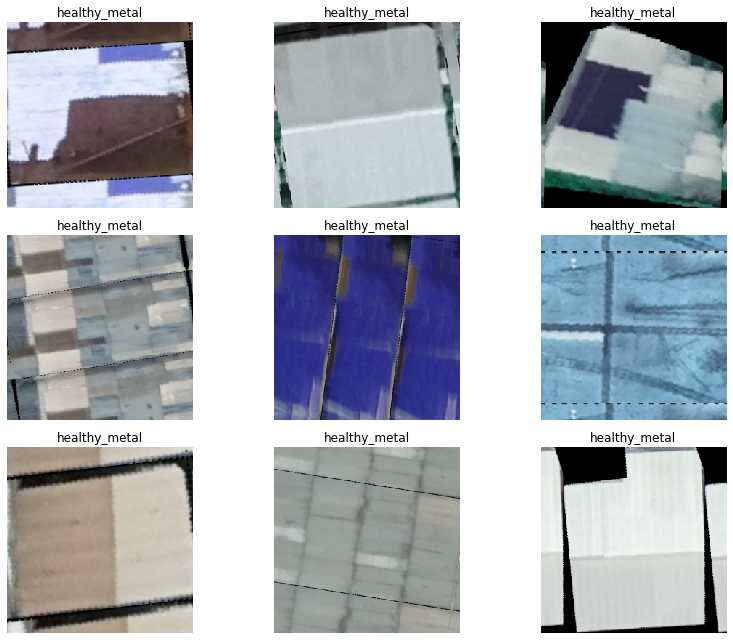

In [32]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [33]:
arch = models.resnet50
arch_name = 'rn50'

In [34]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [34]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


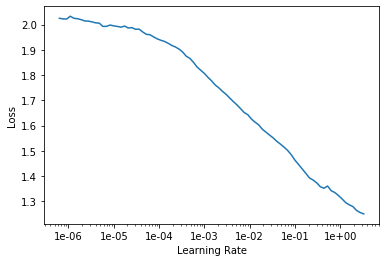

In [36]:
learn.recorder.plot()

Then we can fit the head of our network.

In [37]:
lr = 1e-1

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.515477,0.604511,0.185366,01:10
1,0.486304,0.518506,0.176497,01:10
2,0.451289,0.417051,0.150998,01:08
3,0.399213,0.390563,0.142350,01:06
4,0.388993,0.369708,0.128825,01:08


In [40]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [41]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequ

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 198),
 ('healthy_metal', 'irregular_metal', 140),
 ('incomplete', 'irregular_metal', 64),
 ('other', 'healthy_metal', 36),
 ('concrete_cement', 'healthy_metal', 34),
 ('healthy_metal', 'concrete_cement', 20),
 ('incomplete', 'concrete_cement', 18),
 ('concrete_cement', 'irregular_metal', 15),
 ('incomplete', 'healthy_metal', 14),
 ('irregular_metal', 'incomplete', 11),
 ('irregular_metal', 'concrete_cement', 10),
 ('other', 'irregular_metal', 7),
 ('healthy_metal', 'incomplete', 6),
 ('concrete_cement', 'incomplete', 4)]

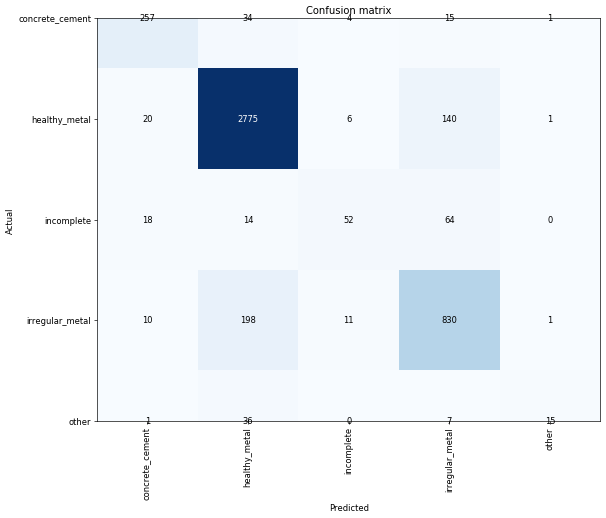

In [43]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


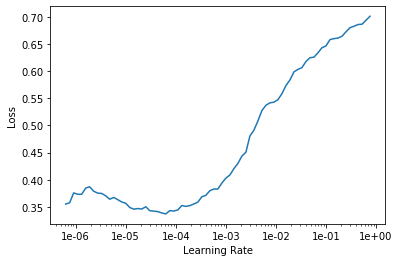

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.442305,nan,0.159202,01:26
1,0.447036,0.420752,0.141242,01:16
2,0.407063,0.420239,0.156098,01:13
3,0.388171,0.372642,0.131486,01:13
4,0.358222,0.356647,0.127494,01:12


In [47]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [48]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequ

In [49]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.394278,0.430669,0.162749,01:13
1,0.398859,0.406669,0.147894,01:13
2,0.386455,0.389117,0.135477,01:13
3,0.363643,0.391651,0.133703,01:12
4,0.333846,0.354364,0.127273,01:12


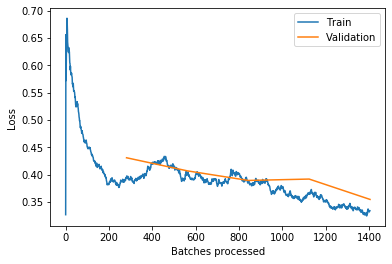

In [50]:
learn.recorder.plot_losses()

In [51]:
learn.save(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

### Load, convert to fp32, export

In [35]:
learn.load(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/wrap/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/wrap/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequ

In [36]:
learn = learn.to_fp32()

In [37]:
learn.export(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [38]:
learn.export()

### Larger size images

In [45]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [46]:
learn.freeze()

In [47]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 10.73 GiB total capacity; 8.32 GiB already allocated; 940.06 MiB free; 621.31 MiB cached)

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save(f'stage-1-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


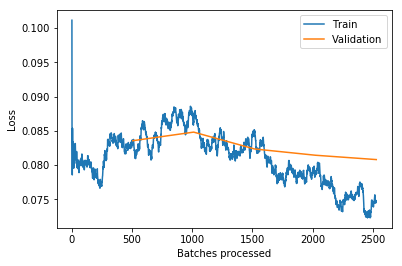

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(f'stage-2-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID})

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

### inference

In [39]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [40]:
len(test_dataset)

7325

In [41]:
learn = load_learner(path=data_dir/f'train/rotated/wrap/{img_size}', test=test_dataset)

In [42]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [43]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [44]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [45]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [46]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [47]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [48]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [49]:
labels = np.argmax(preds, 1)

In [50]:
len(preds)

7325

In [51]:
preds[0].tolist()

[0.045336201786994934,
 0.9439783692359924,
 0.0018191536655649543,
 0.006208794191479683,
 0.0026575785595923662]

In [52]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [53]:
len(labels)

7325

In [54]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [55]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [56]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [57]:
test_predictions[0]

'healthy_metal'

In [58]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [59]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/wrap/256/7a4d9168.tif'), PosixPath('data/test/rotated/wrap/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/wrap/256/7a48ca98.tif'), PosixPath('data/test/rotated/wrap/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/wrap/256/7a486800.tif'), PosixPath('data/test/rotated/wrap/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/wrap/256/7a501f50.tif'), PosixPath('data/test/rotated/wrap/256/7a4d27b4.tif')],
      dtype=object)

In [60]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [61]:
preds_list[0]

[0.045336201786994934,
 0.9439783692359924,
 0.0018191536655649543,
 0.006208794191479683,
 0.0026575785595923662]

In [62]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [63]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [64]:
df.head()

,id,pred
0,7a4d9168,"[0.045336201786994934, 0.9439783692359924, 0.0..."
1,7a4ae922,"[0.007743568159639835, 0.9190315008163452, 0.0..."
2,7a48ca98,"[0.0021731657907366753, 0.3148678243160248, 0...."
3,7a49c614,"[0.0006718412623740733, 0.910446286201477, 0.0..."
4,7a4dd4f2,"[0.0016273654764518142, 0.8780519366264343, 0...."


In [65]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [66]:
pred_df.insert(loc=0, column='id', value=ids)

In [67]:
pred_df.columns = cols

In [69]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.045336,0.943978,0.001819,0.006209,0.002658
1,7a4ae922,0.007744,0.919032,0.003781,0.066851,0.002592
2,7a48ca98,0.002173,0.314868,0.005751,0.675395,0.001813
3,7a49c614,0.000672,0.910446,0.000775,0.087445,0.000662
4,7a4dd4f2,0.001627,0.878052,0.001725,0.110010,0.008586


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [70]:
#pred_df = pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [71]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.045336,0.943978,0.001819,0.006209,0.002658
1,7a4ae922,0.007744,0.919032,0.003781,0.066851,0.002592
2,7a48ca98,0.002173,0.314868,0.005751,0.675395,0.001813
3,7a49c614,0.000672,0.910446,0.000775,0.087445,0.000662
4,7a4dd4f2,0.001627,0.878052,0.001725,0.110010,0.008586


In [72]:
pred_ids=pred_df['id'].values.tolist()

In [73]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [74]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [75]:
baseline_ids=df_baseline['id'].values.tolist()

In [76]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [77]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [78]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [79]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.045336,0.943978,0.001819,0.006209,0.002658,7a4d9168
1,7a4ae922,0.007744,0.919032,0.003781,0.066851,0.002592,7a4ae922
2,7a48ca98,0.002173,0.314868,0.005751,0.675395,0.001813,7a48ca98
3,7a49c614,0.000672,0.910446,0.000775,0.087445,0.000662,7a49c614
4,7a4dd4f2,0.001627,0.878052,0.001725,0.110010,0.008586,7a4dd4f2


In [80]:
pred_df=pred_df.sort_values('id_cat')

In [81]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.008194,0.985527,0.000808,0.004125,0.001346,7a4d630a
764,7a4bbbd6,0.001288,0.979816,0.000454,0.018025,0.000417,7a4bbbd6
1841,7a4ac744,0.009848,0.814844,0.004812,0.169515,0.000981,7a4ac744
3363,7a4881fa,0.004072,0.124904,0.009511,0.860757,0.000755,7a4881fa
133,7a4aa4a8,0.007145,0.570956,0.003422,0.417129,0.001348,7a4aa4a8


In [82]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [84]:
assert len(pred_df)==7325

In [85]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [86]:
### submission 4: 0.4531

### Plot test predictions

In [90]:
pred_df.drop(columns=['id'],inplace=True)

In [91]:
classes=pred_df.idxmax(axis=1)

In [93]:
type(classes)

pandas.core.series.Series

In [95]:
len(classes)

7325

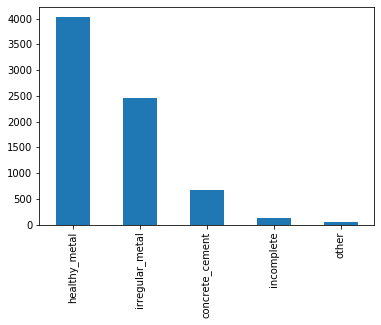

In [97]:
pd.value_counts(classes).plot(kind="bar")